In [112]:
# Imports

from glob import glob
import os
import librosa
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sn
from sklearn.decomposition import PCA
import random

import sklearn.naive_bayes as nb
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier as dec_tree

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize





In [4]:
### STEP 2 ###

loc = './pr_lab1_2020-21_data/digits'

'''
parse_free_digits(loc)
'''

def data_parser(directory):
    files = glob(os.path.join(directory, "*.wav"))
    fnames = [f.split('/')[3].split('.')[0] for f in files]
    # extract ids from filename
    ids = [int(f[-2]+f[-1]) if f[-2].isdigit() else int(f[-1]) for f in fnames]
    # extract float arrays of signals
    waves = [librosa.load(fpath,sr=None)[0] for fpath in files]
    # extract digits from filenames
    digits = []
    for i in range(len(fnames)):
        if str(ids[i]) in fnames[i]:
            fnames[i] = fnames[i].replace(str(ids[i]),'')
    
    return waves, ids, fnames


In [5]:
waves, ids, fnames = data_parser(loc)

print(f"{fnames[0]}{ids[0]} is a {type(waves[0])} with shape {waves[0].shape}")

four8 is a <class 'numpy.ndarray'> with shape (12703,)


In [6]:
### STEP 3 ###

waves, _, _ = data_parser(loc)

def extract_mfcc(waves, num_mfcc=13, window=25, step=10):
    '''
    returns list of np.arrays of shape (frames of signal x num_mfcc)
    '''
    w = window*16 ## length of window in samples
    s = step*16  ## length of step in samples
    mfccs = [
        librosa.feature.mfcc(y=wav, n_mfcc=num_mfcc, n_fft=w, hop_length=s).T ## by default returns (MFCC x Frames) shape
        for wav in tqdm(waves, desc='Extracting MFCC features...')
    ]
    deltas = [librosa.feature.delta(mfcc) for mfcc in mfccs]
    ddeltas = [librosa.feature.delta(d) for d in deltas]
    
    print(f'Feature extraction completed: {num_mfcc} MFCCs per frame.')
    return mfccs, deltas, ddeltas


def extract_mfsc(waves, num_mfsc=13, window=25, step=10):
    '''
    returns list of np.arrays of shape (frames of signal x num_mfsc)
    '''
    w = window*16 ## length of window in samples
    s = step*16  ## length of step in samples
    mfscs = [
        librosa.feature.melspectrogram(y=wav, n_mels=num_mfsc, n_fft=w, hop_length=s).T ## by default returns (MFSC x Frames) shape
        for wav in tqdm(waves, desc='Extracting MFSC features...')
    ]
    
    print(f'Feature extraction completed: {num_mfsc} MFSCs per frame.')
    return mfscs



In [7]:
mfccs, deltas, ddeltas = extract_mfcc(waves)

print(f"{fnames[0]}{ids[0]} has {mfccs[0].shape[0]} frames of {mfccs[0].shape[1]} MFCCs")

print(f"Derivatives have a shape of {deltas[0].shape}")

mfscs = extract_mfsc(waves)

print(f"{fnames[0]}{ids[0]} has {mfscs[0].shape[0]} frames of {mfscs[0].shape[1]} MFSCs")


Extracting MFCC features...:   0%|          | 0/133 [00:00<?, ?it/s]/home/dimitris/.local/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Extracting MFCC features...: 100%|██████████| 133/133 [00:01<00:00, 103.51it/s]


Feature extraction completed: 13 MFCCs per frame.
four8 has 80 frames of 13 MFCCs
Derivatives have a shape of (80, 13)


Extracting MFSC features...: 100%|██████████| 133/133 [00:00<00:00, 383.91it/s]

Feature extraction completed: 13 MFSCs per frame.
four8 has 80 frames of 13 MFSCs


Extracting MFCC features...:   0%|          | 0/133 [00:00<?, ?it/s]/home/dimitris/.local/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Extracting MFCC features...: 100%|██████████| 133/133 [00:03<00:00, 43.51it/s]


Feature extraction completed: 13 MFCCs per frame.


Extracting MFSC features...: 100%|██████████| 133/133 [00:00<00:00, 324.04it/s]


Feature extraction completed: 13 MFSCs per frame.


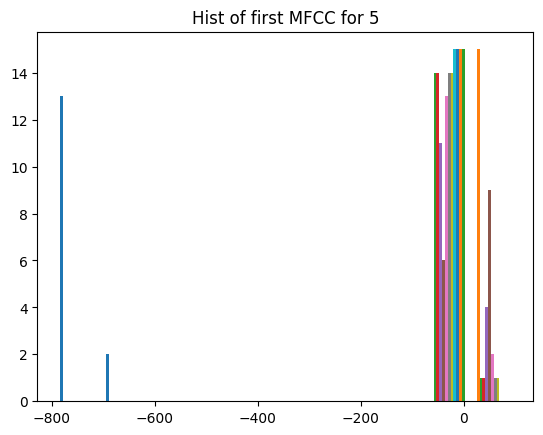

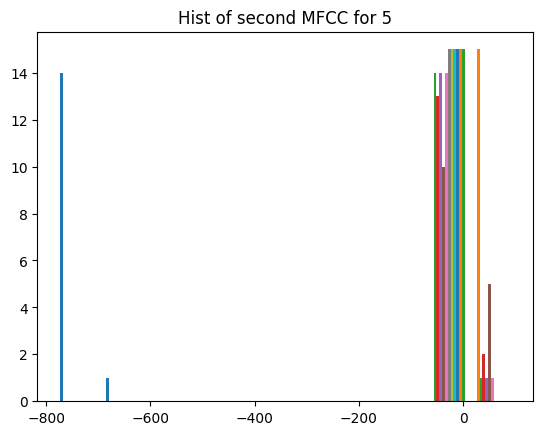

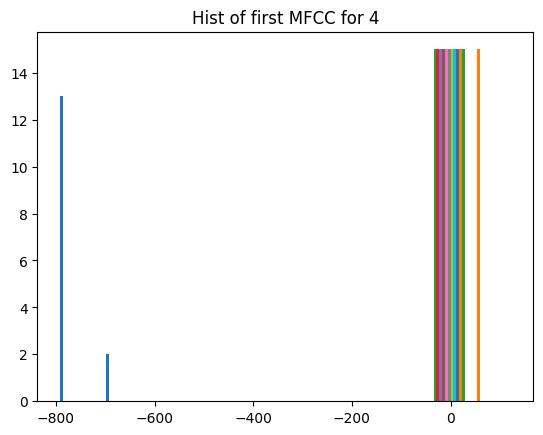

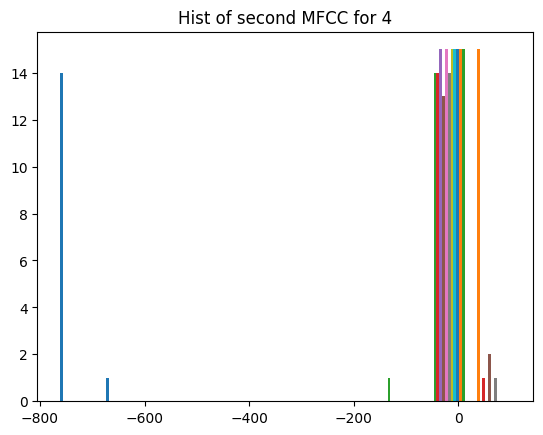

In [40]:
### STEP 4 ### 

loc = './pr_lab1_2020-21_data/digits'

n1 = 5 # Damianos
n2 = 4 # Aravanis

ston = {'zero':0, 'one':1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7, 'eight':8, 'nine':9}

waves, ids, digits = data_parser(loc)
mfccs, deltas, ddeltas = extract_mfcc(waves)

digits = [ston[d] for d in digits]

mfscs = extract_mfsc(waves)

def find_indices(lista,item):
    indices = []
    for idx, value in enumerate(lista):
        if value == item:
            indices.append(idx)
    return indices

def plot_feats(kind,feats,digits,n1=5,n2=4):
    ## find indices of the wav files for n1 and n2
    n1_indices = find_indices(digits,n1)
    n2_indices = find_indices(digits,n2)
    
    ## find the MFFCs feature vectors for the selected coefficients
    n1_feat0 = []
    n1_feat1 = []
    for i in n1_indices:
        n1_feat0.append(feats[i][:][0])
        n1_feat1.append(feats[i][:][1])
        
    n2_feat0 = []
    n2_feat1 = []
    for i in n2_indices:
        n2_feat0.append(feats[i][:][0])
        n2_feat1.append(feats[i][:][1])
        
    plt.hist(np.array(n1_feat0))
    plt.title(f"Hist of first {kind} for {n1}")
    plt.show()
    plt.hist(np.array(n1_feat1))
    plt.title(f"Hist of second {kind} for {n1}")
    plt.show()
    plt.hist(np.array(n2_feat0))
    plt.title(f"Hist of first {kind} for {n2}")
    plt.show()
    plt.hist(np.array(n2_feat1))
    plt.title(f"Hist of second {kind} for {n2}")
    plt.show()
    
    
plot_feats('MFCC',mfccs,digits,n1,n2)


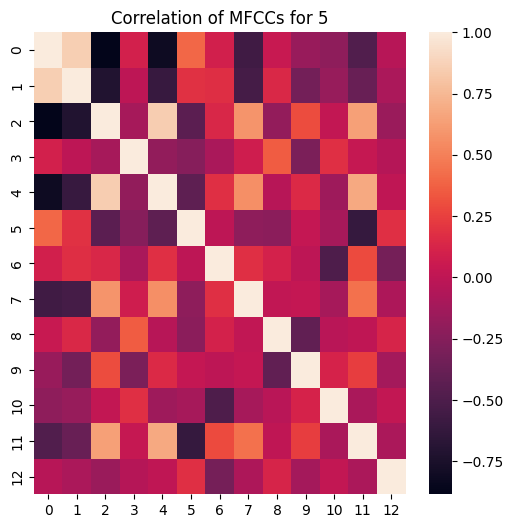

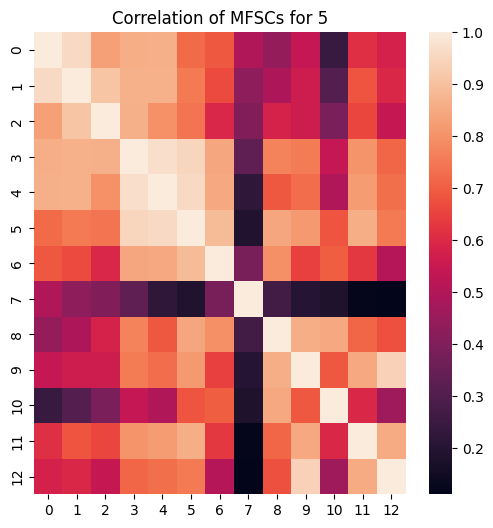

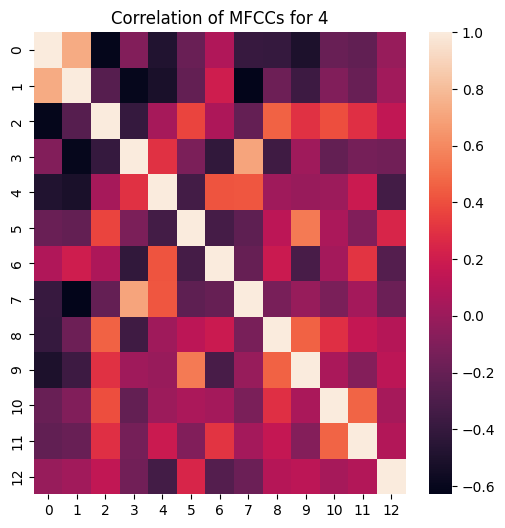

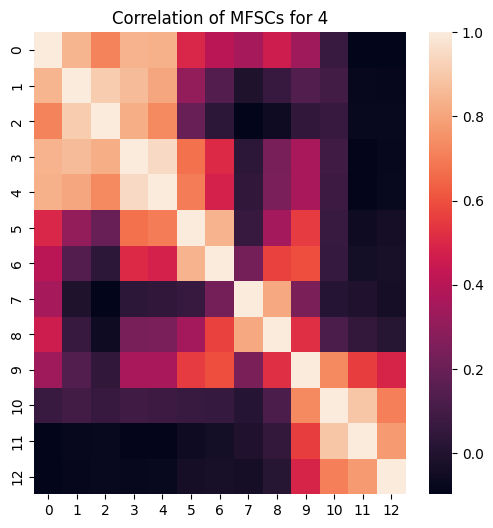

In [10]:
# Find two transcriptions for n1

i = 0
two_n1 = []
for idx, value in enumerate(digits):
    if value == n1:
        two_n1.append(idx)
        i +=1
        if i == 2:
            break

corr_matrix = np.corrcoef(np.concatenate((mfccs[two_n1[0]],mfccs[two_n1[1]]), axis=0).T)
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(corr_matrix, ax=ax)
plt.title(f"Correlation of MFCCs for {n1}")
plt.show()

corr_matrix = np.corrcoef(np.concatenate((mfscs[two_n1[0]],mfscs[two_n1[1]]), axis=0).T)
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(corr_matrix, ax=ax)
plt.title(f"Correlation of MFSCs for {n1}")
plt.show()
        
# Find two transcriptions for n2

i = 0
two_n2 = []
for idx, value in enumerate(digits):
    if value == n2:
        two_n2.append(idx)
        i +=1
        if i == 2:
            break

corr_matrix = np.corrcoef(np.concatenate((mfccs[two_n2[0]],mfccs[two_n2[1]]), axis=0).T)
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(corr_matrix, ax=ax)
plt.title(f"Correlation of MFCCs for {n2}")
plt.show()  

corr_matrix = np.corrcoef(np.concatenate((mfscs[two_n2[0]],mfscs[two_n2[1]]), axis=0).T)
fig, ax = plt.subplots(figsize=(6,6))
sn.heatmap(corr_matrix, ax=ax)
plt.title(f"Correlation of MFSCs for {n2}")
plt.show()


In [68]:
### STEP 5 ###

features = [np.concatenate((mfccs[i],deltas[i],ddeltas[i]), axis=1) for i in range(len(mfccs))]
features[0].shape

(80, 39)

(78,)


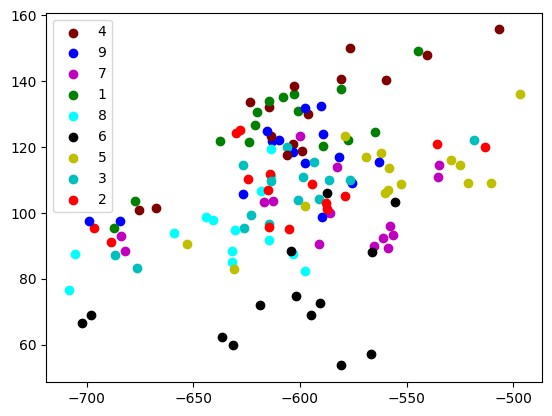

In [12]:
def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys(), loc='upper left')


feature_vectors = [np.concatenate((np.mean(features[i], axis=0),np.std(features[i], axis=0))) 
                  for i in range(len(features))]

print(feature_vectors[0].shape)

ntoc = {1:'g', 2:'r', 3:'c', 4:'maroon', 5:'y',
        6:'k', 7:'m', 8:'aqua', 9:'b'}

for idx, vec in enumerate(feature_vectors):
    x = vec[0]
    y = vec[1]
    plt.scatter(x,y,color=ntoc[digits[idx]],label=digits[idx])
    
legend_without_duplicate_labels(plt)
plt.show()
        

(133, 78)
The variance of the two components : [0.61310875 0.10540757]


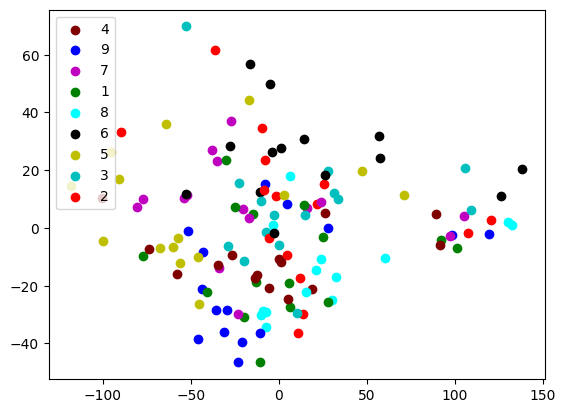

(133, 3)
The variance of the three components : [0.61310875 0.10540757 0.10259702]


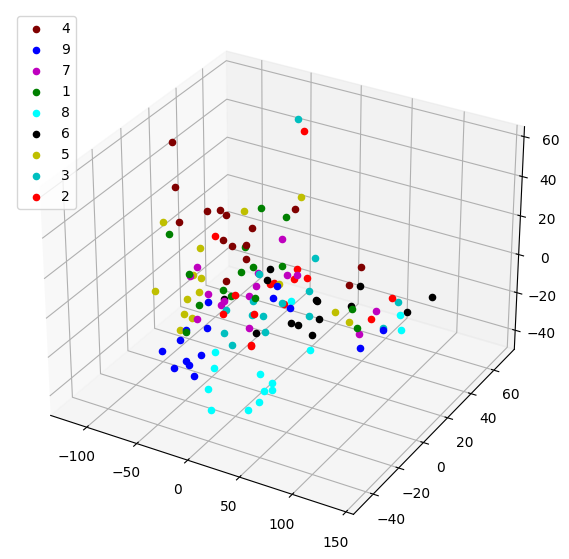

In [13]:
### STEP 6 ### 
'''
TODO: this PCA implementation needs discussion.
'''

data = np.asarray(feature_vectors)
print(data.shape)

pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3)

# Two dim PCA

two_dim = pca_2.fit_transform(data)

print(f"The variance of the two components : {pca_2.explained_variance_ratio_}")

for idx, vec in enumerate(two_dim):
    x = vec[0]
    y = vec[1]
    plt.scatter(x,y,color=ntoc[digits[idx]],label=digits[idx])
    
legend_without_duplicate_labels(plt)
plt.show()

# Three dim PCA

three_dim = pca_3.fit_transform(data)
print(three_dim.shape)

print(f"The variance of the three components : {pca_3.explained_variance_ratio_}")

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
    
for idx, vec in enumerate(three_dim):
    x = vec[0]
    y = vec[1]
    z = vec[2]
 
    ax.scatter3D(x, y, z, color=ntoc[digits[idx]],label=digits[idx])

    
legend_without_duplicate_labels(plt)
plt.show()
        

In [117]:
### STEP 7 ###
print(f"Extracted features number: {len(features)}, 1st feature shape:{features[0].shape}")
'''
Each feature is np.array of shape (num of windows) x (MFFCs = 3*13 = 39)
'''

### modify data ###
def create_dataset(data,labels):
    '''
    Returns list of tuples: (label, feature vector with this label)
    
    Each feature vector is a row from a feature table in data.
    THE IDEA: each vector of each MFCC table is a feature vector that belongs to a certain class
    '''
    res = []
    for idx,table in enumerate(data):
        for vec in table:
            res.append((labels[idx],normalize([vec])[0]))
    return res
    
   

def split_data(dataset,train_perc = 0.7, test_perc = 0.3):
    '''
    Input: dataset (list of tuples) , train percentage, test percentage
    Output: train data,train labels,test data, test labels
    '''
    if train_perc+test_perc != 1:
        print("ERROR:Train and test percantages must add to 1.")
        return
    
    ## select train_perc*all data random ids 
    train_ids = random.sample(range(0,len(dataset)-1),int(train_perc*len(dataset)))
    
    ## split data according to random ids
    x_train = [dataset[i][1] for i in train_ids]
    y_train = [dataset[i][0] for i in train_ids]
    
    x_test = [dataset[i][1] for i in range(len(dataset)-1) if i not in train_ids]
    y_test = [dataset[i][0] for i in range(len(dataset)-1) if i not in train_ids]
    
    return x_train, y_train, x_test, y_test




Extracted features number: 133, 1st feature shape:(80, 39)


In [118]:
dataset = create_dataset(features,digits)
x_train, y_train, x_test, y_test = split_data(dataset)

print(f'Percentages: train:{len(x_train)/len(dataset)}, test:{len(x_test)/len(dataset)}')
print(f'Data shape:{np.shape(x_test)}')
print(f'Labels shape:{np.shape(y_test)}')

Percentages: train:0.6999240554395292, test:0.2999810138598823
Data shape:(3160, 39)
Labels shape:(3160,)


In [119]:
#### Model training ####

## 1st model: gaussian naive bayes model training and testing
gnb = nb.GaussianNB()
gnb.fit(x_train,y_train)

gnb_predictions = gnb.predict(x_test)

In [120]:
## 2nd mosel: MLP
mlp_model = mlp(random_state=1, max_iter=300)
mlp_model.fit(x_train, y_train)
mlp_predictions = mlp_model.predict(x_test)

/home/dimitris/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [121]:
## 3rd model: k-nn
knn_model = knn(n_neighbors=13)
knn_model.fit(x_train,y_train)
knn_predictions = knn_model.predict(x_test)

In [122]:
## 4th model: decision tree 
decTree_model = dec_tree()
decTree_model.fit(x_train, y_train)
decTree_predictions = decTree_model.predict(x_test)

In [123]:
### Test the quality of predictions

## Check accuracy:
gnb_acc = accuracy_score(y_test, gnb_predictions)
mlp_acc = accuracy_score(y_test, mlp_predictions)
knn_acc = accuracy_score(y_test, knn_predictions)
decTree_acc = accuracy_score(y_test, decTree_predictions)

print(f"Naive Bayes acc: {gnb_acc}\nMLP acc: {mlp_acc} \nK-NN acc: {knn_acc} \nDecision Tree acc: {decTree_acc}")


### BONUS NOT IMPLEMENTED 
### FOR BETTER RESULTS: find the best 2/3 features through PCA and train the models using 2x1 or 3x1 vectors

Naive Bayes acc: 0.2208860759493671
MLP acc: 0.4 
K-NN acc: 0.5056962025316456 
Decision Tree acc: 0.37468354430379747
